# PCA pipeline

## Libraries and classes, functions

In [1]:
import os, sys
sys.path.append(os.path.abspath('../'))
from src.utils import load_extracted_data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

    
def extract_stepwise_statistics(tabular):
    '''
    extract stepwise statistic(mean)
    '''
    param_names = list(tabular.columns)
    for name in tabular.columns:
        if (name in ('time', 'dataset', 'wafer_count', 'file_path')) or (name.startswith('_step')):
            param_names.remove(name)
    step_nums = [int(name.split('_')[2]) for name in tabular.columns if name.startswith('_step')]

    stepwise = pd.concat([
        tabular[param_names].groupby(tabular[f'_step_{step:0>2}']).aggregate('mean').drop(index=-1)
        for step in step_nums], 
        axis=1, 
        keys=step_nums
    ).sort_index()

    stepwise = pd.concat([
        tabular['time'].groupby(tabular['wafer_count']).aggregate('min').drop(index=-1), 
        stepwise
    ], axis=1)
    stepwise['dataset'] = tabular['dataset'].groupby(tabular['wafer_count']).aggregate('min').drop(index=-1)

    return stepwise


class DropColsWithManyNAs(BaseEstimator, TransformerMixin):
    '''
    columns(variables) with too many NAs are dropped
    '''
    def __init__(self, max_na_ratio=0.4):
        self.max_na_ratio = max_na_ratio
    
    def fit(self, X, y=None):
        self._mask_use_cols = np.mean(np.isnan(X), axis=0) <= self.max_na_ratio
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            result = X[X.columns[self._mask_use_cols]]
        else:
            result = X[:, self._mask_use_cols]
        mask_not_na = np.all(~np.isnan(result), axis=1)
        self._mask_not_na = mask_not_na
        return result
        # return result[mask_not_na]


class NAImmunityDecorator(BaseEstimator, TransformerMixin):
    '''
    decorate model to be immune to arrays with NAs
    '''
    def __init__(self, body):
        self.body = body

    def _get_notna_mask(self, X, y=None):
        # if y is None:
        #     y = np.empty(X.shape[:1])
        mask_not_na = np.all(~np.isnan(X), axis=1) # & ~np.isnan(y)
        return mask_not_na

    def fit(self, X, y=None):
        mask_not_na = self._get_notna_mask(X)
        self.body.fit(X[mask_not_na])
        return self
    
    def transform(self, X, y=None):
        mask_not_na = self._get_notna_mask(X)
        tfmed = self.body.transform(X[mask_not_na])
        result = np.empty(X.shape[:1] + tfmed.shape[1:])
        result[mask_not_na] = tfmed
        result[~mask_not_na] = np.nan
        return result

## Load data and build model pipeline

In [3]:
extracted_df = load_extracted_data('../../input/CVD_anomaly_detection/machine1.npz')
stepwise = extract_stepwise_statistics(extracted_df)

X = stepwise.drop(columns=['time', 'dataset'])
time = stepwise['time']
ds_assign = stepwise['dataset']

mask_train = stepwise['dataset'] == 0
mask_val = stepwise['dataset'].isin([2, 3])
mask_non_test = mask_train | mask_val

model = make_pipeline(
    DropColsWithManyNAs(),
    RobustScaler(with_centering=True),
    PCA(random_state=42)
)
model = NAImmunityDecorator(model)
model.fit(X[mask_train])

NAImmunityDecorator(body=Pipeline(steps=[('dropcolswithmanynas',
                                          DropColsWithManyNAs()),
                                         ('robustscaler', RobustScaler()),
                                         ('pca', PCA(random_state=42))]))

## Plotting results

Text(0.5, 1.0, 'PCA reconstruction error - 3h agg')

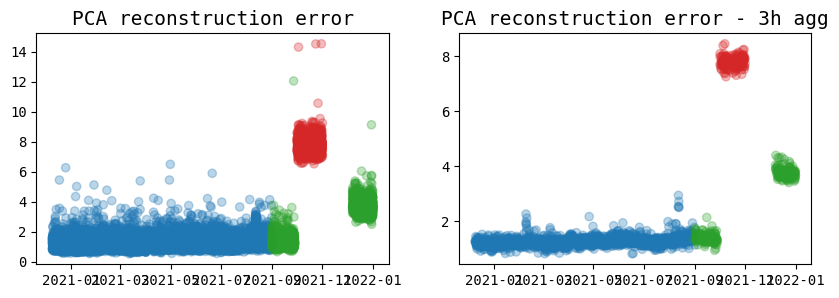

In [4]:
def aggregate_by_time(series, t_ceil, method='mean'):
    return pd.Series(series, index=t_ceil.index).groupby(t_ceil).agg(method)

codim = 60

recon_err = np.linalg.norm(model.transform(X)[:, -codim:], axis=-1)


fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

ax = axs[0]
ax.scatter(
    time[mask_non_test], recon_err[mask_non_test], c=ds_assign[mask_non_test],
    cmap='tab10', vmin=0, vmax=9, alpha=0.3
)
ax.set_title('PCA reconstruction error', fontsize=14)

latency = '3h'
t_ceil = time.dt.ceil(latency)
ax = axs[1]

ax.scatter(
    aggregate_by_time(time[mask_non_test], t_ceil[mask_non_test], 'max'),
    aggregate_by_time(recon_err[mask_non_test], t_ceil[mask_non_test], 'mean'),
    c=aggregate_by_time(ds_assign[mask_non_test], t_ceil[mask_non_test], 'max'),
    # time[mask_non_test].groupby(t_ceil[mask_non_test]).agg('max'), 
    # recon_err[mask_non_test].groupby(t_ceil[mask_non_test]).agg('mean'), 
    # c=ds_assign[mask_non_test].groupby(t_ceil[mask_non_test].agg('max')),
    cmap='tab10', vmin=0, vmax=9, alpha=0.3
)
ax.set_title('PCA reconstruction error - 3h agg', fontsize=14)